In [2]:
import sys
sys.path.append('../..')
sys.path.append('../../APDFT')
sys.path.append('../../helper_code')
sys.path.append('../data')

import pickle
from pyscf import gto, scf, dft, cc
from ase import Atoms
import numpy as np
import pandas as pd
import pyscf
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import basis_set_exchange as bse
from APDFT.FcMole import *
import os
import ast
from copy import deepcopy
from IPython.display import display
from helper_code.data_processing import *


%load_ext autoreload
%autoreload 2
from APDFT.AP_class import APDFT_perturbator as AP

## Load Dataset ##

In [3]:
coronene_energy_raw_data = np.load("../data/coronene_raw_data/coronene_mutants_pbe0_pcx2.npz", allow_pickle=True)
charges, total_energy = coronene_energy_raw_data['charges'], coronene_energy_raw_data['energies']

columns = ['charges', 'total energy']
coronene_energy_data = pd.DataFrame(columns=columns)
coronene_energy_data['charges'] = charges.tolist()
coronene_energy_data['total energy'] = total_energy.tolist()

CORONENE_REF_ENERGY = -909.721935153841
coronene_energy_data['delta total energy'] = coronene_energy_data['total energy'].apply(lambda x: CORONENE_REF_ENERGY-x)

display(coronene_energy_data.head(3))

,charges,total energy,delta total energy
0,"[7, 5, 5, 5, 5, 7, 5, 7, 5, 5, 7, 7, 5, 7, 6, ...",-946.036986,36.315051
1,"[6, 5, 7, 6, 6, 6, 6, 6, 6, 6, 5, 7, 6, 5, 7, ...",-929.442623,19.720687
2,"[6, 5, 7, 5, 5, 5, 7, 5, 5, 6, 5, 7, 7, 5, 6, ...",-942.508112,32.786177


In [4]:
hessian_data = np.load("coronene_pbe0_pcX2_hessian.npz", allow_pickle=True)
H = hessian_data['H']
ANM_eigval, Q = np.linalg.eig(H)
Q_inv = np.linalg.inv(Q)

## Data Processing ##

In [5]:
ref_charge = 6* np.ones((24,))

coronene_energy_data['dx'] = coronene_energy_data['charges'].apply(
    lambda arr: (np.array(arr[:24]) - ref_charge).astype(int))

coronene_energy_data['dx_lexi'] = coronene_energy_data['dx'].apply(
    lambda arr: lexi_transformation(arr))

coronene_energy_data['c'] = coronene_energy_data['dx'].apply(
    lambda arr: (arr.reshape(1, 24) @ Q).reshape(24,).tolist()) # column vector view: c = Q_inv @ dx

coronene_energy_data['c_lexi'] = coronene_energy_data['dx_lexi'].apply(
    lambda arr: (arr.reshape(1, 24) @ Q).reshape(24,).tolist())

coronene_energy_data['CE'] = coronene_energy_data['c'].apply(
    lambda arr: compute_lambda_c(arr, ANM_eigval))

coronene_energy_data['CE_lexi'] = coronene_energy_data['c_lexi'].apply(
    lambda arr: compute_lambda_c(arr, ANM_eigval))

coronene_energy_data['CSE'] = coronene_energy_data['c'].apply(
    lambda arr: compute_lambda_c_square(arr, ANM_eigval))

coronene_energy_data['CSE_lexi'] = coronene_energy_data['c_lexi'].apply(
    lambda arr: compute_lambda_c_square(arr, ANM_eigval))

# print(coronene_energy_data['dx'][0])
# print(coronene_energy_data['dx_lexi'][0])
# print(coronene_energy_data['c'][0])
# print(coronene_energy_data['CSE'][0])
# display(coronene_energy_data.head(3))

In [6]:
coronene_energy_data['second order alchemy'] = coronene_energy_data['CSE_lexi'].apply(lambda arr: sum(arr))
coronene_energy_data['delta delta total energy'] = coronene_energy_data['delta total energy'] + coronene_energy_data['second order alchemy']
# print(coronene_energy_data['delta total energy'].mean())
# print(coronene_energy_data['delta delta total energy'].mean())
# display(coronene_energy_data[['second order alchemy', 'delta total energy', 'delta delta total energy']])

## Export Data ##

In [7]:
datasets = ['c', 'c_lexi', 'CE', 'CE_lexi', 'CSE', 'CSE_lexi']
columns = [f"coord{i}" for i in range(24)]

dataset_dict = {}
for data in datasets:
    dataset_dict[data] = pd.DataFrame(columns=columns)
    for i in range(24):
        dataset_dict[data][f"coord{i}"] = coronene_energy_data[data].apply(lambda arr: arr[i])

# display(dataset_dict['CSE_lexi'])

In [8]:
for key, dataframe in dataset_dict.items():
    dataframe.to_csv(f'../data/coronene_training_data/{key}.csv', index=False)

In [44]:
coronene_energy_data['delta total energy'].to_csv('../data/coronene_training_data/delta_total_energy.csv', index=False)
coronene_energy_data['delta delta total energy'].to_csv('../data/coronene_training_data/delta_delta_total_energy.csv', index=False)

## Feature Distribution ##

[ 0.03149719 -0.95444256  0.06845424 ... -0.41500065 -0.65654901
 -1.39101926]


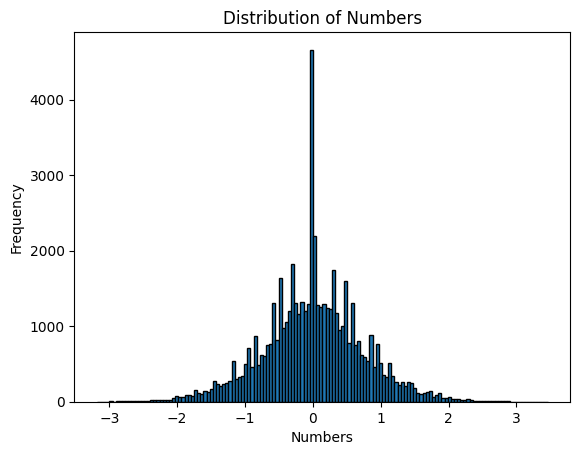

In [10]:
C = np.vstack(coronene_energy_data['c'].tolist()).flatten()
print(C)
# Plot the histogram
plt.hist(C, bins='auto', edgecolor='black')
plt.xlabel('Numbers')
plt.ylabel('Frequency')
plt.title('Distribution of Numbers')

plt.show()

[ 2.69183756e-03 -7.57368811e-01 -3.89586377e-03 ... -2.61577533e-01
 -6.31253557e-01 -2.83358374e+00]


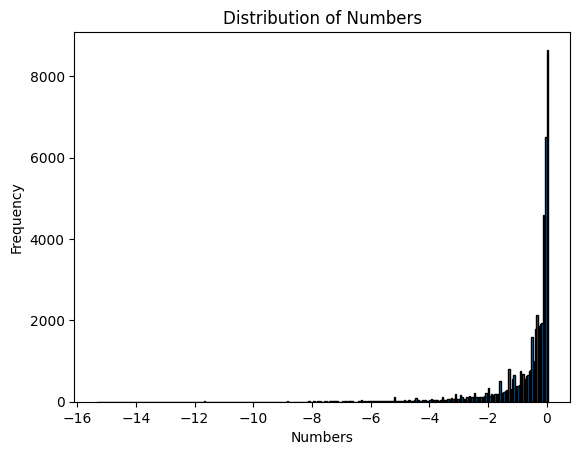

In [9]:
CSE = np.vstack(coronene_energy_data['CSE'].tolist()).flatten()
print(CSE)
# Plot the histogram
plt.hist(CSE, bins='auto', edgecolor='black')
plt.xlabel('Numbers')
plt.ylabel('Frequency')
plt.title('Distribution of Numbers')

plt.show()

[ 0.08546279  0.79351953 -0.05691195 ...  0.63030633  0.96147211
  2.03705573]


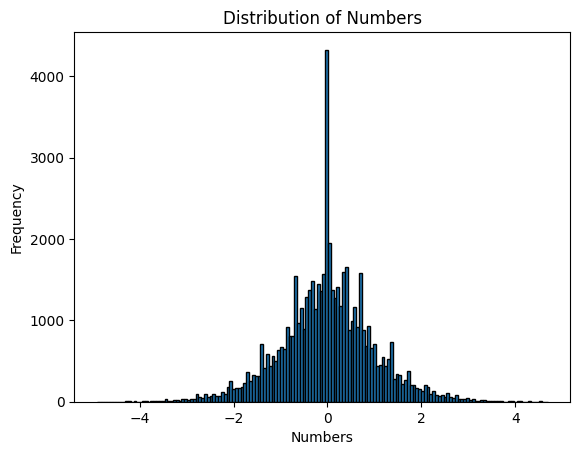

In [9]:
CE = np.vstack(coronene_energy_data['CE'].tolist()).flatten()
print(CE)
# Plot the histogram
plt.hist(CE, bins='auto', edgecolor='black')
plt.xlabel('Numbers')
plt.ylabel('Frequency')
plt.title('Distribution of Numbers')

plt.show()